In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import ast
from datetime import datetime
from enum import Enum
from typing import List, Optional, Tuple, Dict, Any
import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines3 import SAC, PPO, A2C, DDPG, TD3, DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure
from tqdm.notebook import tqdm
import torch
from torch import nn
import csv

### Data Model Classes

In [2]:
class Customer:
    def __init__(self, idx: int, zip_code: int, city: str, state: str, num_products: int):
        self.idx = idx
        self.zip_code = zip_code
        self.city = city
        self.state = state
        self.views = [0] * num_products
        self.likes = [0] * num_products
        self.purchases = [0] * num_products
        self.ratings = [0] * num_products

In [3]:
class Category:
    def __init__(self, idx: int, name: str, desc: str):
        self.idx = idx
        self.name = name
        self.desc = desc

In [4]:
class Product:
    def __init__(self, idx: int, name: str, desc: str, long_desc: str, category: Category, price: float) -> None:
        self.idx = idx
        self.name = name
        self.desc = desc
        self.long_desc = long_desc
        self.category = category
        self.price = price

In [5]:
class InteractionType(Enum):
    NONE = "none"
    VIEW = "view"
    LIKE = "like"
    BUY = "buy"
    RATE = "rate"
    EXIT = "exit"
    SESSION_START = "session_start"
    SESSION_CLOSE = "session_close"


class Interaction:
    def __init__(
        self,
        idx: str,
        timestamp: datetime,
        product_idx: int,
        customer_idx: int,
        type: InteractionType,
        value: float = 0.0,
        review_score: Optional[int] = None,
    ):
        self.idx = idx
        self.timestamp = timestamp
        self.product_idx = product_idx
        self.customer_idx = customer_idx
        self.type = type
        self.value = value
        self.review_score = review_score

### Data Loader Functions

In [6]:
data_dir = "../data/cleaned/"

In [7]:
def load_customers(num_products: int, interactions: List[Interaction], product_id_to_index: Dict[int, int], idxs: List[int] = []) -> List[Customer]:
    customer_df = pd.read_csv(f"{data_dir}Customer.csv")

    if idxs:
        customer_df = customer_df[customer_df["idx"].isin(idxs)]

    # Reset index to get zero-based indices
    customer_df.reset_index(drop=True, inplace=True)
    customer_id_to_index = {row["idx"]: idx for idx, row in customer_df.iterrows()}

    # Create a dictionary to hold customer interactions
    customer_interactions = {}
    for interaction in interactions:
        cust_id = interaction.customer_idx
        if cust_id not in customer_id_to_index:
            continue  # Skip if customer not found
        cust_idx = customer_id_to_index[cust_id]

        if cust_idx not in customer_interactions:
            customer_interactions[cust_idx] = {
                "views": [0] * num_products,
                "likes": [0] * num_products,
                "purchases": [0] * num_products,
                "ratings": [0] * num_products,
            }

        product_idx = interaction.product_idx
        if product_idx not in product_id_to_index:
            continue  # Skip if product not found
        prod_idx = product_id_to_index[product_idx]

        if interaction.type == InteractionType.VIEW:
            customer_interactions[cust_idx]["views"][prod_idx] += 1
        elif interaction.type == InteractionType.LIKE:
            customer_interactions[cust_idx]["likes"][prod_idx] += 1
        elif interaction.type == InteractionType.BUY:
            customer_interactions[cust_idx]["purchases"][prod_idx] += 1
            customer_interactions[cust_idx]["ratings"][prod_idx] = interaction.review_score if interaction.review_score else 0
        elif interaction.type == InteractionType.RATE:
            customer_interactions[cust_idx]["ratings"][prod_idx] = interaction.review_score if interaction.review_score else 0

    customers = []
    for idx, row in customer_df.iterrows():
        cust_idx = idx
        # Initialize with interaction data if available
        interactions_data = customer_interactions.get(cust_idx, {})
        views = interactions_data.get("views", [0] * num_products)
        likes = interactions_data.get("likes", [0] * num_products)
        purchases = interactions_data.get("purchases", [0] * num_products)
        ratings = interactions_data.get("ratings", [0] * num_products)

        # Create customer instance
        customer = Customer(idx=cust_idx, zip_code=row["zip_code"], city=row["city"], state=row["state"], num_products=num_products)

        # Assign interaction data
        customer.views = views
        customer.likes = likes
        customer.purchases = purchases
        customer.ratings = ratings
        customers.append(customer)

    return customers, customer_id_to_index

In [8]:
def load_categories(idxs: List[int] = []) -> List[Category]:
    category_df = pd.read_csv(f"{data_dir}Category.csv")
    if idxs:
        category_df = category_df[category_df["idx"].isin(idxs)]

    categories = [Category(idx=row["idx"], name=row["name"], desc=row["desc"]) for _, row in category_df.iterrows()]
    return categories

In [9]:
def load_products(idxs: List[int] = []) -> Tuple[List[Product], float, Dict[int, int]]:
    product_df = pd.read_csv(f"{data_dir}Product.csv")
    category_df = pd.read_csv(f"{data_dir}Category.csv")

    # Create a dictionary to map category IDs to Category objects
    category_map = {row["idx"]: Category(idx=row["idx"], name=row["name"], desc=row["desc"]) for _, row in category_df.iterrows()}

    if idxs:
        product_df = product_df[product_df["idx"].isin(idxs)]

    # Reset index to get zero-based indices
    product_df.reset_index(drop=True, inplace=True)
    product_id_to_index = {row["idx"]: idx for idx, row in product_df.iterrows()}

    products = [
        Product(
            idx=idx,  # Use zero-based index
            name=row["name"],
            desc=row["desc"],
            long_desc=row["long_desc"],
            category=category_map.get(row["category_num_id"]),
            price=row["price"],
        )
        for idx, row in product_df.iterrows()
    ]

    # Calculate the maximum price for setting price levels
    max_price = product_df["price"].max()
    return products, max_price, product_id_to_index

In [10]:
def load_interactions(
    product_id_to_index: Dict[int, int], customer_id_to_index: Dict[int, int], idxs: List[int] = [], customer_idxs: List[int] = [], k: int = 0
) -> List[Interaction]:
    interaction_df = pd.read_csv(f"{data_dir}Interaction.csv")

    # Filter by index or customer if specified
    if idxs:
        interaction_df = interaction_df[interaction_df["idx"].isin(idxs)]
    elif customer_idxs:
        interaction_df = interaction_df[interaction_df["customer_idx"].isin(customer_idxs)]

    # Limit to the last k interactions, sorted by timestamp
    if k > 0:
        interaction_df = interaction_df.sort_values(by="timestamp", ascending=False).head(k)

    # Process each interaction with proper parsing and index mapping
    interactions = []
    for _, row in interaction_df.iterrows():
        cust_id = row["customer_idx"]
        prod_id = row["product_idx"]

        if cust_id not in customer_id_to_index or prod_id not in product_id_to_index:
            continue  # Skip if customer or product not found

        interaction = Interaction(
            idx=row["idx"],
            timestamp=datetime.strptime(row["timestamp"], "%Y-%m-%d %H:%M:%S"),
            customer_idx=customer_id_to_index[cust_id],
            product_idx=product_id_to_index[prod_id],
            type=InteractionType(row["type"]),
            value=row["value"],
            review_score=row["review_score"],
        )
        interactions.append(interaction)

    return interactions

In [11]:
# Load products and create mappings
products, max_price, product_id_to_index = load_products()
num_products = len(products)

# Create placeholder customer mapping (will be filled in load_customers)
customer_id_to_index = {}

# Load interactions with mappings
interactions = load_interactions(product_id_to_index, customer_id_to_index)

# Now load customers with mappings
customers, customer_id_to_index = load_customers(num_products, interactions, product_id_to_index)

### Custom Environment

In [ ]:
class RecommendationEnv(gym.Env):
    def __init__(self, users: List[Customer], products: List[Product], top_k: int, max_price: float, price_interval: int = 500):
        super().__init__()

        # Initialize users and products data
        self.users = users
        self.products = products
        self.num_products = len(products)
        self.top_k = top_k  # Number of top recommendations
        self.user_idx = 0  # Index of the current user
        self.current_step = 0  # Step count in the current episode
        self.categories = load_categories()  # Load category data
        self.num_categories = len(self.categories)
        self.possible_interactions = [
            InteractionType.NONE,
            InteractionType.VIEW,
            InteractionType.LIKE,
            InteractionType.BUY,
            InteractionType.RATE,
            InteractionType.SESSION_CLOSE,
        ]

        # Define price levels based on max price and price interval
        self.num_price_levels = int(np.ceil(max_price / price_interval))
        self.price_interval = price_interval

        # Initialize the random number generator
        self.seed()

        # Define the action space
        self.action_space = spaces.Discrete(self.num_products)

        # Define the observation space
        self.observation_space = spaces.Dict(
            {
                "pref_prod": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32),
                "pref_cat": spaces.Box(low=0, high=1, shape=(self.num_categories,), dtype=np.float32),
                "purchase": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32),
                "viewed": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32),
                "liked": spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32),
                "ratings": spaces.Box(low=0, high=5, shape=(self.num_products,), dtype=np.float32),
            }
        )

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        # Reset the environment to start a new episode
        self.user_idx = self.np_random.integers(0, len(self.users))
        self.current_step = 0
        return self._get_observation()

    def step(self, action):
        # Execute one time step within the environment
        self.current_step += 1  # Increment step count
        user = self.users[self.user_idx]  # Get the current user

        # Decode the action
        decoded_action = self.decode_action(action)
        recommended_product_idx = decoded_action["product_idx"]

        # Calculate the probability of each interaction type based on user preferences
        product_pref = self._get_product_preferences(user)[recommended_product_idx]
        interaction_probs = self._calculate_interaction_probabilities(product_pref)

        # Simulate user interaction based on probabilities
        interaction_type = self.np_random.choice(a=self.possible_interactions, p=interaction_probs)

        # Define rating_value based on interaction_type
        rating_value = self.np_random.integers(1, 6) if interaction_type == InteractionType.RATE else 0

        # Calculate the reward and check if the episode is done
        reward = self._calculate_reward(interaction_type, rating_value)
        done = interaction_type == InteractionType.SESSION_CLOSE  # Episode ends if session is closed

        # Update the user's observation based on the interaction
        obs = self._update_observation(recommended_product_idx, interaction_type, rating_value)

        return obs, reward, done, {}

    def decode_action(self, action):
        # Action directly corresponds to product index
        product_idx = action
        return {"product_idx": product_idx}

    def _calculate_interaction_probabilities(self, product_pref):
        # Ensure product_pref is within [0, 1]
        product_pref = np.clip(product_pref, 0.0, 1.0)

        # Example probabilities based on product preference
        base_prob = 0.05  # Adjusted base probability
        interaction_probs = {
            InteractionType.VIEW: base_prob + 0.2 * product_pref,
            InteractionType.LIKE: base_prob + 0.15 * product_pref,
            InteractionType.BUY: base_prob + 0.1 * product_pref,
            InteractionType.RATE: base_prob + 0.05 * product_pref,
            InteractionType.SESSION_CLOSE: 0.05,  # Fixed small probability
        }
        # Compute total probability so far
        total_prob = sum(interaction_probs.values())
        # Compute NONE probability as the remaining probability
        interaction_probs[InteractionType.NONE] = max(0.0, 1.0 - total_prob)
        # Ensure all probabilities are non-negative
        interaction_probs = {k: max(0.0, v) for k, v in interaction_probs.items()}

        # Get probabilities in the order of possible_interactions
        probs = [interaction_probs[itype] for itype in self.possible_interactions]

        # Normalize probabilities
        total = sum(probs)
        if total == 0:
            # Handle the case where all probabilities are zero
            probs = [1.0 / len(probs)] * len(probs)
        else:
            probs = [prob / total for prob in probs]

        return probs

    def _calculate_reward(self, interaction_type, rating_value):
        # Define rewards based on interaction type and rating
        if interaction_type == InteractionType.NONE:
            return -1
        elif interaction_type == InteractionType.VIEW:
            return 1
        elif interaction_type == InteractionType.LIKE:
            return 3
        elif interaction_type == InteractionType.BUY:
            return 20
        elif interaction_type == InteractionType.RATE:
            return (rating_value - 3) * 2  # Encourage high ratings
        elif interaction_type == InteractionType.SESSION_CLOSE:
            return -1
        else:
            return 0

    def _update_observation(self, product_idx, interaction_type, rating_value):
        # Update the user's interaction data based on the interaction
        user = self.users[self.user_idx]

        if interaction_type == InteractionType.VIEW:
            user.views[product_idx] += 1
        elif interaction_type == InteractionType.LIKE:
            user.likes[product_idx] += 1
        elif interaction_type == InteractionType.BUY:
            user.purchases[product_idx] += 1
        elif interaction_type == InteractionType.RATE:
            user.ratings[product_idx] = rating_value

        # Return the updated observation
        return self._get_observation()

    def _get_observation(self):
        # Construct the observation dictionary
        user = self.users[self.user_idx]
        max_views = max(user.views) if max(user.views) > 0 else 1
        max_purchases = max(user.purchases) if max(user.purchases) > 0 else 1
        max_likes = max(user.likes) if max(user.likes) > 0 else 1

        observation = {
            "pref_prod": self._get_product_preferences(user),
            "pref_cat": self._get_category_preferences(user),
            "purchase": np.array(user.purchases, dtype=np.float32) / max_purchases,
            "viewed": np.array(user.views, dtype=np.float32) / max_views,
            "liked": np.array(user.likes, dtype=np.float32) / max_likes,
            "ratings": np.array(user.ratings, dtype=np.float32),
        }
        return observation

    def _get_product_preferences(self, user):
        # Calculate dynamic maximums for normalization
        max_view = max(user.views) if max(user.views) > 0 else 1
        max_purchase = max(user.purchases) if max(user.purchases) > 0 else 1
        max_like = max(user.likes) if max(user.likes) > 0 else 1
        max_rating = max(user.ratings) if max(user.ratings) > 0 else 5

        # Calculate preferences dynamically
        view_pref = np.array(user.views, dtype=np.float32) / max_view
        purchase_pref = np.array(user.purchases, dtype=np.float32) / max_purchase
        like_pref = np.array(user.likes, dtype=np.float32) / max_like
        rate_pref = (np.array(user.ratings, dtype=np.float32) - 3.0) / max_rating

        # Combine preferences and normalize
        product_pref = view_pref + purchase_pref + like_pref + rate_pref
        max_pref = np.max(product_pref) if np.max(product_pref) > 0 else 1
        product_pref = np.clip(product_pref / max_pref, 0.0, 1.0)

        return product_pref

    def _get_category_preferences(self, user):
        # Calculate category preferences by summing interactions per category
        category_pref = np.zeros(self.num_categories, dtype=np.float32)
        for product_idx in range(self.num_products):
            category = self.products[product_idx].category
            if category is not None:
                category_idx = category.idx  # Assuming category.idx is zero-based
                category_pref[category_idx] += user.views[product_idx] + user.purchases[product_idx]
        total_pref = np.sum(category_pref)
        if total_pref > 0:
            category_pref = category_pref / total_pref
        return category_pref

    def render(self, mode="human"):
        # Optional: implement visualization if needed
        print(f"Current User Index: {self.user_idx}")
        print(f"Step: {self.current_step}")

    def close(self):
        # Optional: implement any necessary cleanup
        pass

### Initialize environment

In [13]:
# Initialize the environment with users and products
env = RecommendationEnv(users=customers, products=products, top_k=5, max_price=max_price)

# Wrap the environment for vectorized training
vec_env = make_vec_env(lambda: env, n_envs=1)

c:\Users\farha\miniconda3\envs\rl_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


#### Logging

In [ ]:
# Custom callback to log rewards for plotting
class RewardLoggingCallback(BaseCallback):
    def __init__(self, log_file="training_rewards_dqn.csv", verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.rewards = []
        self.episode_lengths = []  # Track episode lengths
        self.current_episode_length = 0
        self.log_file = log_file

        # Open the file in write mode and add a header row for the CSV log
        with open(self.log_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Timestep", "Reward"])

    def _on_step(self) -> bool:
        # Get reward and done
        reward = self.locals.get("rewards")
        done = self.locals.get("dones")

        if reward is not None:
            reward_value = reward[0]  # Since there's only one environment
            self.rewards.append(reward_value)

            # Append the reward and timestep to the CSV file
            with open(self.log_file, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([self.num_timesteps, reward_value])

        if done is not None:
            if done[0]:
                self.episode_lengths.append(self.current_episode_length)
                self.current_episode_length = 0
            else:
                self.current_episode_length += 1

        return True

In [16]:
# Output directory
output_dir = "./outputs/"

# Set up TensorBoard logging directory
tensorboard_log_dir = f"{output_dir}tensorboard_logs/"
model_save_path = f"{output_dir}dqn_recommender"
os.makedirs(tensorboard_log_dir, exist_ok=True)

# Configure TensorBoard logger
new_logger = configure(tensorboard_log_dir, ["tensorboard"])

### Initialize model

In [ ]:
policy_kwargs = dict(
    net_arch=[256, 256],
    activation_fn=nn.ReLU,
)

model = DQN(
    policy="MultiInputPolicy",
    env=vec_env,
    verbose=1,
    learning_rate=1e-3,
    buffer_size=100000,
    batch_size=64,
    learning_starts=1000,
    target_update_interval=1000,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.1,
    tensorboard_log=tensorboard_log_dir,
    policy_kwargs=policy_kwargs,
)

model.set_logger(new_logger)

Using cuda device


In [ ]:
# Initialize custom callbacks
total_timesteps = 100000

# Callbacks for logging rewards and epsilon values
reward_callback = RewardLoggingCallback(log_file=f"{output_dir}training_rewards_dqn.csv")

In [ ]:
# Train the model with both progress and reward logging callbacks
model.learn(
    total_timesteps=total_timesteps,
    callback=[
        reward_callback,
    ],
    progress_bar=True,
)

Output()

In [20]:
# Save the trained model
model.save(model_save_path)

### Plots

In [25]:
# # Plotting training rewards over timesteps
# def plot_training_metrics(rewards):
#     plt.figure(figsize=(10, 5))
#     plt.plot(rewards, label="Reward")
#     plt.xlabel("Timesteps")
#     plt.ylabel("Reward")
#     plt.title("Reward vs. Timesteps")
#     plt.legend()
#     plt.show()


# Moving average of rewards
def plot_moving_average_rewards(rewards, window=50):
    moving_avg_rewards = np.convolve(rewards, np.ones(window) / window, mode="valid")
    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg_rewards, label="Moving Average Reward (Window = {})".format(window))
    plt.xlabel("Timesteps")
    plt.ylabel("Moving Average Reward")
    plt.title("Moving Average of Reward vs. Timesteps")
    plt.legend()
    plt.show()


# Cumulative reward plot
def plot_cumulative_rewards(rewards):
    cumulative_rewards = np.cumsum(rewards)
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_rewards, label="Cumulative Reward")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward vs. Timesteps")
    plt.legend()
    plt.show()


# Plot episode lengths
def plot_episode_lengths(episode_lengths):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episodes")
    plt.ylabel("Episode Length")
    plt.title("Episode Length vs. Episodes")
    plt.legend()
    plt.show()

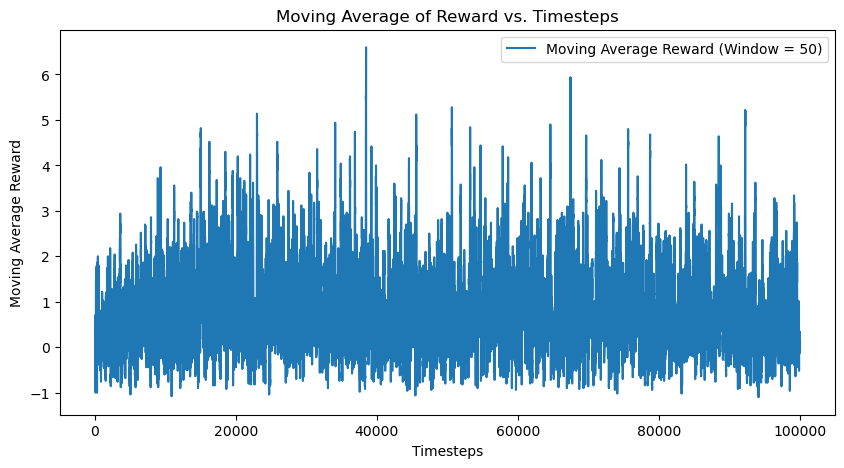

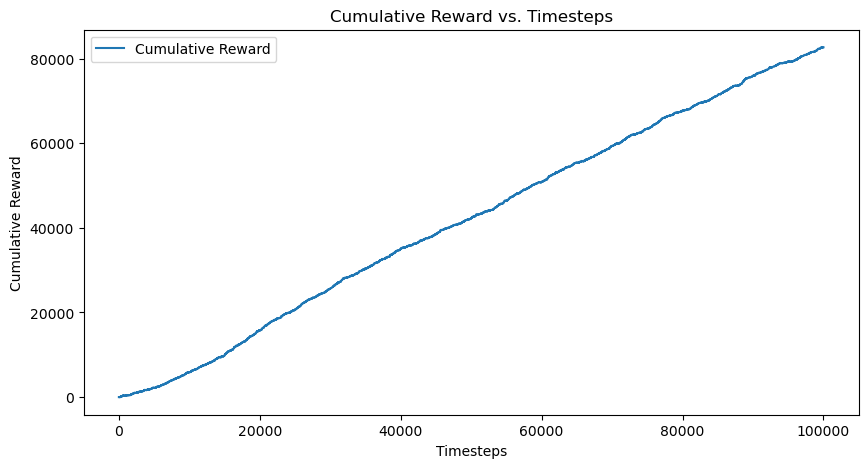

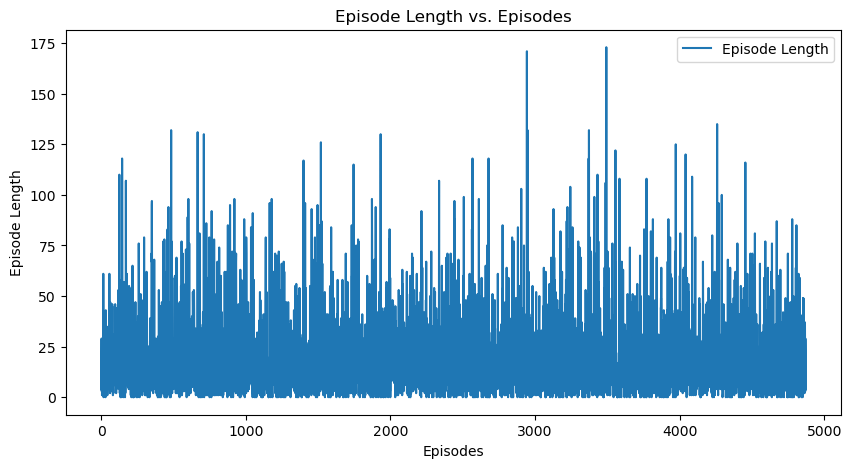

In [26]:
# # Plot training rewards
# plot_training_metrics(reward_callback.rewards)

# Plot moving average of rewards
plot_moving_average_rewards(reward_callback.rewards)

# Plot cumulative rewards
plot_cumulative_rewards(reward_callback.rewards)

# Plot episode lengths
plot_episode_lengths(reward_callback.episode_lengths)